In [1]:
import pandas as pd
import toolz as fp

In [16]:
labels_df = pd.read_pickle("labels_df.pkl")
lists_df = pd.read_pickle("lists_df.pkl")
actions_df = pd.read_pickle("actions_df.pkl")
cards_df = pd.read_pickle("cards_df.pkl")

In [17]:
labels_df.head()

,id,name,color
0,5c773e16c7522c4e23a71268,Movie,green
1,5c773e16c7522c4e23a71264,TV Series,yellow
2,5c773e16c7522c4e23a71267,Anime/Cartoon,orange
3,5c773e16c7522c4e23a71266,Documentary,blue
4,5c773e16c7522c4e23a71265,Book,sky


In [19]:
lists_df.head()

,id,name,pos
0,5c773e16c7522c4e23a71252,BACKLOG,65535
1,5c773e16c7522c4e23a71253,TO DO,131071
2,5c773e16c7522c4e23a71254,IN PROGRESS,196607
3,5c773e16c7522c4e23a71255,REVIEW,229375
4,5c773e16c7522c4e23a71256,DONE,262143


In [5]:
@fp.curry
def rn(group, order): # row_number operation
    group = group.sort_values(by=[order])
    group["row_number"] = (
        group
        .reset_index(drop=True)
        .reset_index()
        .index
        + 1
    )
    return group

In [6]:
# get the first action of a card
card_by_temporal_creation = (
    actions_df.assign(date=lambda df: pd.to_datetime(df.date))
    .groupby("data_card_id")
    .apply(rn(order="date"))
    .loc[lambda df: df.row_number == 1][
        ["type", "date", "data_card_id", "data_card_name"]
    ]
    .assign(date=lambda df: pd.to_datetime(df.date))
    .rename(columns={"data_card_id": "id"})
)


# joins it with the card + labels information
card_with_label_info = (
    cards_df[["id", "desc", "name", "idLabels"]]
    .explode("idLabels")
    .merge(
        labels_df.rename(columns={"id": "idLabels", "name": "nameLabel"}),
        on="idLabels",
        how="left",
    )
)

# joins both so we have: date of action ("creation date"), card info as well as labels
final_card_creation_info_df = card_with_label_info.merge(
    card_by_temporal_creation, on="id", how="left"
).assign(creation_date=lambda df: df.date.dt.strftime("%Y-%m-%d"))
final_card_creation_info_df.head()

,id,desc,name,idLabels,nameLabel,color,type,date,data_card_name,creation_date
0,62cae10b6a1e3a35d3d75821,,Oldboy,5c773e16c7522c4e23a71268,Movie,green,copyCard,2022-07-10 14:24:11.751000+00:00,Oldboy,2022-07-10
1,630f875414406f0092df2945,,This is the end,5c773e16c7522c4e23a71268,Movie,green,updateCard,2022-08-31 16:07:48.709000+00:00,This is the end,2022-08-31
2,5f3042888f97376f39a6429b,https://junji-ito-index.tumblr.com/the-index,Uzumaki - Vol 3,5c773e16c7522c4e23a71265,Book,sky,copyCommentCard,2020-08-02 20:38:02.783000+00:00,Uzumaki - Vol 3,2020-08-02
3,5f3042888f97376f39a6429b,https://junji-ito-index.tumblr.com/the-index,Uzumaki - Vol 3,5c773e16c7522c4e23a71267,Anime/Cartoon,orange,copyCommentCard,2020-08-02 20:38:02.783000+00:00,Uzumaki - Vol 3,2020-08-02
4,633d65bf247f41006f5cc980,,Hamilton,5c773e16c7522c4e23a71268,Movie,green,copyCard,2022-10-05 11:08:47.899000+00:00,Hamilton,2022-10-05


corner case: For some reason these cards here don't have any related actions to it ???

In [7]:
# ggggg.to_csv("weird_card_with_no_related_action.csv")
pd.read_csv("weird_card_with_no_related_action.csv")

,Unnamed: 0,id,desc,name,idLabels,nameLabel,color,yy
0,0,5dc7765564fb7a67b6b4ebce,NaN,Shadow of Mordor,5c773e16c7522c4e23a71269,Game,purple,NaN
1,1,5ded0f42131b2349f17f7edf,NaN,Ovos verdes e presunto,5c773e16c7522c4e23a71267,Anime/Cartoon,orange,NaN
2,2,5e0b7cebbb3635630f8a2877,NaN,Bacurau,5c773e16c7522c4e23a71268,Movie,green,NaN
3,3,5d1bed4fd6a44c534b3fd566,NaN,Atlanta,5c773e16c7522c4e23a71264,TV Series,yellow,NaN
4,4,5da10e3b982ccc3ee6a7e942,NaN,Alladin,5c773e16c7522c4e23a71268,Movie,green,NaN
5,5,5d757c1e65e9395fedc6c542,NaN,Titans,5c773e16c7522c4e23a71264,TV Series,yellow,NaN
6,6,5d3e142e4978703369fa8759,NaN,Yakusoku no neverland,5c773e16c7522c4e23a71267,Anime/Cartoon,orange,NaN
7,7,5d30baeeaf34700bead9c1e4,NaN,Coherence,5c773e16c7522c4e23a71268,Movie,green,NaN


## Queries

For each year, get cards that were created in that year broken down by the category they belong to (labels).

In [8]:
final_card_creation_info_df.head()

,id,desc,name,idLabels,nameLabel,color,type,date,data_card_name,creation_date
0,62cae10b6a1e3a35d3d75821,,Oldboy,5c773e16c7522c4e23a71268,Movie,green,copyCard,2022-07-10 14:24:11.751000+00:00,Oldboy,2022-07-10
1,630f875414406f0092df2945,,This is the end,5c773e16c7522c4e23a71268,Movie,green,updateCard,2022-08-31 16:07:48.709000+00:00,This is the end,2022-08-31
2,5f3042888f97376f39a6429b,https://junji-ito-index.tumblr.com/the-index,Uzumaki - Vol 3,5c773e16c7522c4e23a71265,Book,sky,copyCommentCard,2020-08-02 20:38:02.783000+00:00,Uzumaki - Vol 3,2020-08-02
3,5f3042888f97376f39a6429b,https://junji-ito-index.tumblr.com/the-index,Uzumaki - Vol 3,5c773e16c7522c4e23a71267,Anime/Cartoon,orange,copyCommentCard,2020-08-02 20:38:02.783000+00:00,Uzumaki - Vol 3,2020-08-02
4,633d65bf247f41006f5cc980,,Hamilton,5c773e16c7522c4e23a71268,Movie,green,copyCard,2022-10-05 11:08:47.899000+00:00,Hamilton,2022-10-05


In [68]:
query = """
    creation_date >= '2022-01-01'
"""
## groupby year, month, category and count
info_by_year_df = (
    final_card_creation_info_df
    .assign(year=lambda df: df.date.dt.year, 
            month=lambda df: df.date.dt.month)
    .query("~month.isnull()") # remove the weird cards that have null month
    .groupby(["year", "month", "nameLabel"]) # calculate the relative frequency
    [["id"]]
    .size()
    .reset_index(name="count")
    .assign(relative_frequency=lambda df: df.groupby(["year", "month"]).transform(lambda x: x / x.sum()))
    )

/tmp/ipykernel_919/1276986047.py:14: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  .assign(relative_frequency=lambda df: df.groupby(["year", "month"]).transform(lambda x: x / x.sum()))


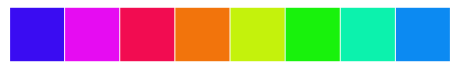

In [26]:
import toolz as fp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_rows', 50)
palette = sns.hls_palette(8, h=.7, s=.9, l=0.5)
sns.palplot(palette)
sns.set_palette(palette)

gray = "444444"

plt.rcParams['figure.facecolor'] = '1'  # background color
plt.rcParams['axes.facecolor'] = '1'  # plot background color

plt.rcParams['grid.color'] = '0.8'
plt.rcParams['grid.alpha'] = .4

plt.rcParams['axes.edgecolor'] = '1'

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['grid.linestyle'] = '-'

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelcolor'] = gray

plt.rcParams['text.color'] = gray

plt.rcParams['xtick.color'] = gray
plt.rcParams['ytick.color'] = gray
sns.set_style("whitegrid")

In [28]:
def update_pointplot_xlabels(multiple_of=5, rotation=0, ax=None, xticks=True):
    """update the xlabels and xticks of the axis passed.
        with this function, it can plot xticks/labels with different periods, using the
        multiple_of parameter
    """
    if ax is None:
        ax = plt.gca()
    new_labels, new_xticks = [], []
    if xticks:
        for i, label in enumerate(ax.get_xticklabels()):
            if i % multiple_of == 0:
                new_labels.append(label)
        for i, tick in enumerate(ax.get_xticks()):
            if i % multiple_of == 0:
                new_xticks.append(tick)
        ax.set_xticks(new_xticks)
    else:
        for i, label in enumerate(ax.get_xticklabels()):
            new_labels.append(label if i % multiple_of == 0 else "")
    ax.set_xticklabels(new_labels, rotation=rotation)


Text(0.5, 1.0, 'Frequency of media style by year')

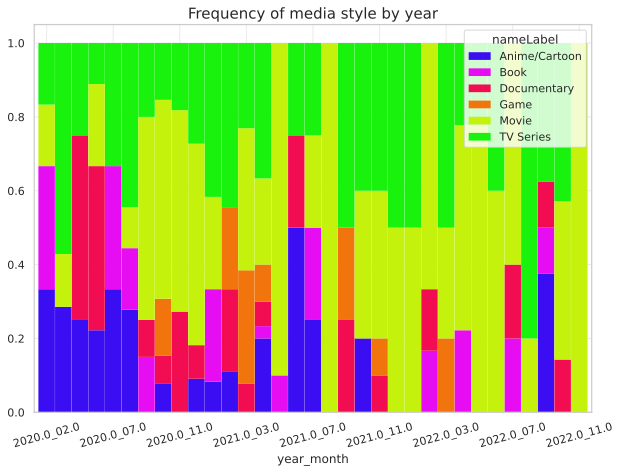

In [75]:
to_plot = info_by_year_df.assign(
    year_month=lambda df: df.year.astype(str) + "_" + df.month.astype(str).str.zfill(4)
)[["year_month", "nameLabel", "relative_frequency"]].pivot_table(
    index=["year_month"],
    columns="nameLabel",
    values="relative_frequency",
    aggfunc="mean",
)
fig, ax = plt.subplots(figsize=(10, 7))
to_plot.plot(kind="bar", stacked=True, rot=0, ax=ax, width=0.99, edgecolor="none")
update_pointplot_xlabels(ax=ax, multiple_of=4, rotation=15)
plt.title("Frequency of media style by year", fontsize=15)